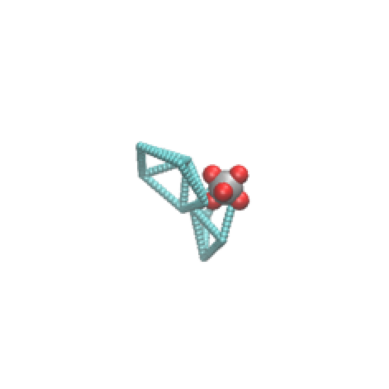

Seed: 0, Accuracy: 0.5944444444444444
Seed: 1, Accuracy: 0.5666666666666667
Seed: 2, Accuracy: 0.6138888888888889
Seed: 3, Accuracy: 0.7027777777777777
Seed: 4, Accuracy: 0.6
Seed: 5, Accuracy: 0.6305555555555555
Seed: 6, Accuracy: 0.625
Seed: 7, Accuracy: 0.5805555555555556
Seed: 8, Accuracy: 0.6388888888888888
Seed: 9, Accuracy: 0.5916666666666667
Average Accuracy: 0.6144444444444446
Standard Deviation of Accuracy: 0.036510610668106104
Standard Error of the Mean Accuracy: 0.011545668847485722


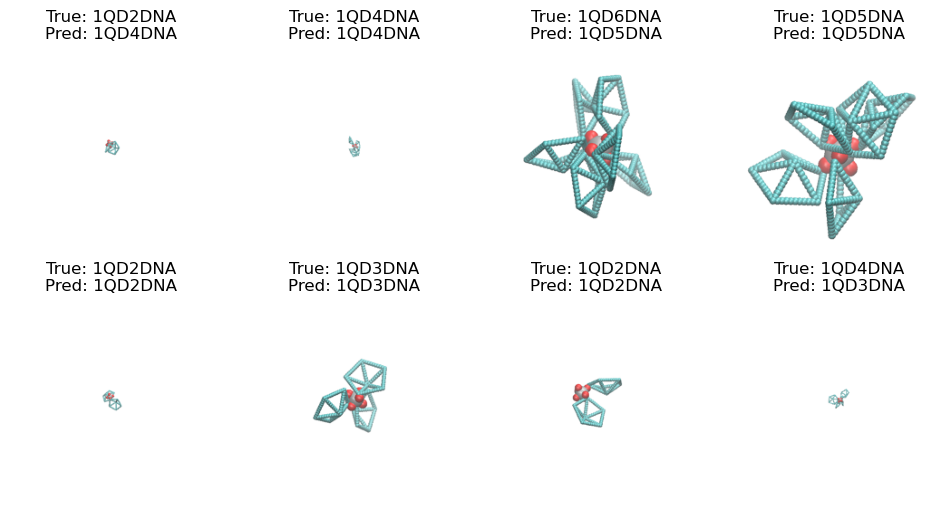

Image: unknown1.png, Predicted class: 1QD5DNA
Image: unknown10.png, Predicted class: 1QD5DNA
Image: unknown11.png, Predicted class: 1QD3DNA
Image: unknown12.png, Predicted class: 1QD3DNA
Image: unknown13.png, Predicted class: 1QD4DNA
Image: unknown14.png, Predicted class: 1QD5DNA
Image: unknown15.png, Predicted class: 1QD3DNA
Image: unknown16.png, Predicted class: 1QD5DNA
Image: unknown17.png, Predicted class: 1QD5DNA
Image: unknown18.png, Predicted class: 1QD5DNA
Image: unknown19.png, Predicted class: 1QD5DNA
Image: unknown2.png, Predicted class: 1QD5DNA
Image: unknown20.png, Predicted class: 1QD5DNA
Image: unknown3.png, Predicted class: 1QD5DNA
Image: unknown4.png, Predicted class: 1QD5DNA
Image: unknown5.png, Predicted class: 1QD5DNA
Image: unknown6.png, Predicted class: 1QD5DNA
Image: unknown7.png, Predicted class: 1QD5DNA
Image: unknown8.png, Predicted class: 1QD5DNA
Image: unknown9.png, Predicted class: 1QD5DNA
Running time: 30.381914854049683 seconds


In [6]:
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import time

start_time = time.time()  # Record the start time

# Function to load images from folder
def load_images_from_folder(folder):
    images = []
    labels = []
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Supported image formats
                img = Image.open(os.path.join(subdir, file)).convert('RGB')
                img = img.resize((224, 224))  # Resize image to 500x500
                images.append(np.array(img))
                label = os.path.basename(subdir)  # Use folder name as label
                labels.append(label)
    return np.array(images), np.array(labels)

# Specify image directories
base_image_directory = '../../simulation'
TEM_image_directory = '../../TEM'
image_path = '../../predictTEM'

# Load image data
images, labels = load_images_from_folder(base_image_directory)

# Display a randomly loaded image (optional)
random_image_index = random.randint(0, len(images) - 1)
random_image = images[random_image_index]
plt.imshow(random_image)
plt.axis('off')
plt.show()

# Preprocess data: flatten image data into 1D vectors
n_samples, height, width, channels = images.shape
data = images.reshape((n_samples, height * width * channels))

# Convert labels to numerical values
label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}
indexed_labels = np.array([label_to_index[label] for label in labels])

# Function to train and evaluate the model
def train_and_evaluate(seed, X, y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

    # Build random forest model
    clf = RandomForestClassifier(random_state=seed)

    # Train the model
    clf.fit(X_train, y_train)

    # Predict the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_test, y_pred

# Train and evaluate the model with different seeds
seeds = range(10)
accuracies = []
all_y_tests = []
all_y_preds = []

for seed in seeds:
    accuracy, y_test, y_pred = train_and_evaluate(seed, data, indexed_labels)
    accuracies.append(accuracy)
    all_y_tests.append(y_test)
    all_y_preds.append(y_pred)
    print(f'Seed: {seed}, Accuracy: {accuracy}')

# Calculate the average accuracy and standard deviation
average_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f'Average Accuracy: {average_accuracy}')
print(f'Standard Deviation of Accuracy: {std_accuracy}')

# Calculate error bars (standard error of the mean)
sem_accuracy = std_accuracy / np.sqrt(len(seeds))
print(f'Standard Error of the Mean Accuracy: {sem_accuracy}')

# Save the trained model with the best seed
best_seed_index = np.argmax(accuracies)
best_seed = seeds[best_seed_index]
best_clf = RandomForestClassifier(random_state=best_seed)
X_train, X_test, y_train, y_test = train_test_split(data, indexed_labels, test_size=0.2, random_state=best_seed)
best_clf.fit(X_train, y_train)
joblib.dump(best_clf, 'random_forest_model_best_seed.pkl')

# Display some prediction results using the best model
y_pred_best = all_y_preds[best_seed_index]

def show_images(images, labels, predictions, num_images=8):
    _, axes = plt.subplots(2, 4, figsize=(12, 6))
    for ax, image, label, prediction in zip(axes.flatten(), images, labels, predictions):
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title(f'True: {label}\nPred: {prediction}')
    plt.show()

# Display some test samples
sample_indices = np.random.choice(len(X_test), 8, replace=False)
sample_images = X_test[sample_indices].reshape((-1, height, width, channels))
sample_labels = [list(label_to_index.keys())[label] for label in y_test[sample_indices]]
sample_predictions = [list(label_to_index.keys())[pred] for pred in y_pred_best[sample_indices]]
show_images(sample_images, sample_labels, sample_predictions)

# Load and use the best model for prediction
def prepare_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((224, 224))
    image = np.array(image).reshape(1, -1)  # Flatten to 1D vector and add batch dimension
    return image

def predict_image(image_path, model):
    image_vector = prepare_image(image_path)
    prediction = model.predict(image_vector)
    class_name = list(label_to_index.keys())[prediction[0]]
    return class_name

# Example usage
image_files = sorted([f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))])

# Load the best model
best_clf = joblib.load('random_forest_model_best_seed.pkl')

# Process each image
for img_file in image_files:
    img_path = os.path.join(image_path, img_file)
    class_name = predict_image(img_path, best_clf)
    print(f'Image: {img_file}, Predicted class: {class_name}')

end_time = time.time()  # Record the end time
print(f"Running time: {end_time - start_time} seconds")